In [1]:
# using plotmaker on v3

import scanpy as sc
import anndata as ad
import pandas as pd
from scipy.sparse import csr_matrix, vstack
import random
import numpy as np
import random
from scipy.io import mmread, mmwrite
from sklearn.neighbors import NearestNeighbors
import plotly.graph_objects as go
import igraph
import seaborn as sns
import matplotlib.pyplot as plt

This code loads the adata object from the H5AD file "scanorama_full_leiden_v2.h5ad", making the data and its associated metadata available for further analysis.

In [2]:
adata = ad.read_h5ad('data/scanorama_full_leiden_v2.h5ad')

This code adds a new column called "ensembl" to the adata.var DataFrame, storing the current gene names (from the index) as values in the "ensembl" column. This step is likely preparing for a future transformation or mapping from Ensembl gene IDs to gene short names, which will be used in visualizations like a marker gene dotplot.

In [3]:
# changes var from ensembl to gene_short_name - used in the marker gene dotplot
adata.var["ensembl"] = adata.var.index.values

This code updates the adata.var index to use the values from the "gene_short_name" column, converting them to strings. After updating the index, it calls adata.var_names_make_unique() to ensure that all gene names are unique by appending suffixes where necessary. 

In [4]:
# changes var from ensembl to gene_short_name - used in the marker gene dotplot
adata.var.index = adata.var["gene_short_name"].values.astype(str)
adata.var_names_make_unique()

This code performs several operations on the adata object and its subsets:

    Filtering and Organizing Data: It creates separate subsets of the adata object for different origins (Disteche, Ian, Cao). It then focuses on the Cao origin to count the number of occurrences of each combination of 'leiden' and 'Main_cluster_name'.
    Calculating Percentages: It calculates the percentage of each 'Main_cluster_name' within each 'leiden' group by first determining the total count per 'leiden' and then computing the percentage for each 'Main_cluster_name'.
    Finding Most Common Clusters: For each 'leiden' group, it finds the most common 'Main_cluster_name' and calculates the percentage, using the same method of determining total counts per 'leiden'.
    Reordering Clusters: It sorts the leiden clusters based on the most common 'Main_cluster_name' and updates the categories for the 'leiden' column in adata_dis, adata_ian, and adata_cao to match this new order.
    Merging Data: It merges the most_common DataFrame with the counts DataFrame on 'leiden' and 'most_common' using a left join, then cleans up unnecessary columns and renames the remaining columns for clarity.

This prepares the adata subsets with updated and consistent cluster information based on the most common 'Main_cluster_name' per 'leiden', with the final output in the result DataFrame containing the total number of cells per cluster.

In [5]:
adata.obs["leiden"] = adata.obs["leiden"].astype(int) 
adata_dis = adata[adata.obs["origin"] == "Disteche"]
adata_ian = adata[adata.obs["origin"] == "Ian"]
adata_cao = adata[adata.obs["origin"] == "Cao"]
cao_obs = adata_cao.obs
# Step 1: Group by 'leiden' and 'Main_cluster_name', and count rows
counts = cao_obs.groupby(['leiden', 'Main_cluster_name']).size().reset_index(name='count')
counts["leiden"] = counts["leiden"].astype(int)
# Step 2: Calculate total counts per leiden value
total_counts = cao_obs.groupby('leiden').size()

# Step 3: Compute percentages
counts['total_rows'] = counts['leiden'].map(total_counts)  # Map total counts to each row
counts['percentage'] = (counts['count'] / counts['total_rows']) * 100
# Step 1: Find the most common Main_cluster_name for each leiden
most_common = cao_obs.groupby('leiden')['Main_cluster_name'].agg(lambda x: x.mode()[0]).reset_index(name='most_common')

# Step 2: Calculate total counts per leiden value
total_counts = cao_obs.groupby('leiden').size()

# Step 3: Compute percentages correctly
most_common['total_rows'] = most_common['leiden'].map(total_counts)  # Map total counts to each row

# Display the result
most_common = most_common.sort_values(by='most_common')

# Get a list of the values in the "leiden" column in the new order
cluster_order = most_common['leiden'].tolist()
most_common_list = most_common["most_common"].tolist()
cluster_len = len(cluster_order)

adata_dis.obs["leiden"] = adata_dis.obs["leiden"].astype(int).astype("category")
adata_ian.obs["leiden"] = adata_ian.obs["leiden"].astype(int).astype("category")
adata_cao.obs["leiden"] = adata_cao.obs["leiden"].astype(int).astype("category")

adata_dis.obs['leiden'] = adata_dis.obs['leiden'].cat.set_categories(cluster_order)
adata_ian.obs['leiden'] = adata_ian.obs['leiden'].cat.set_categories(cluster_order)
adata_cao.obs['leiden'] = adata_cao.obs['leiden'].cat.set_categories(cluster_order)

# Merge `most_common` with `counts` on ('leiden', 'most_common') using a left join
result = pd.merge(most_common, counts, left_on=['leiden', 'most_common'], right_on=['leiden', 'Main_cluster_name'], how='left')
result.drop("Main_cluster_name", axis=1, inplace=True)
result.drop("total_rows_y", axis=1, inplace=True)

# Rename column 'A' to 'new_column_name'
result.rename(columns={'total_rows_x': 'total_cells'}, inplace=True)

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2207328177.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = cao_obs.groupby(['leiden', 'Main_cluster_name']).size().reset_index(name='count')
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2207328177.py:32: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_dis.obs["leiden"] = adata_dis.obs["leiden"].astype(int).astype("category")
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2207328177.py:33: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ian.obs["leiden"] = adata_ian.obs["leiden"].astype(int).astype("category")
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\2207328177.py:34: ImplicitModificationWarning: Trying to modif

Pivot Table: Creates a table with Main_cluster_name as rows and leiden clusters as columns, filled with counts.

Odds Ratio Calculation: Calculates the odds ratio for each combination of cell type and leiden cluster, measuring the association between them.

Heatmap: Plots the odds ratios as a heatmap, displaying the relationship between Cao cell types and leiden clusters.

C:\Users\PC\AppData\Local\Temp\ipykernel_11196\1681978999.py:4: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_table = counts.pivot_table(index='Main_cluster_name', columns='leiden', values='count', fill_value=0)
C:\Users\PC\AppData\Local\Temp\ipykernel_11196\1681978999.py:22: RuntimeWarning: divide by zero encountered in scalar divide
  odds_r = (a / c) / (b / d)


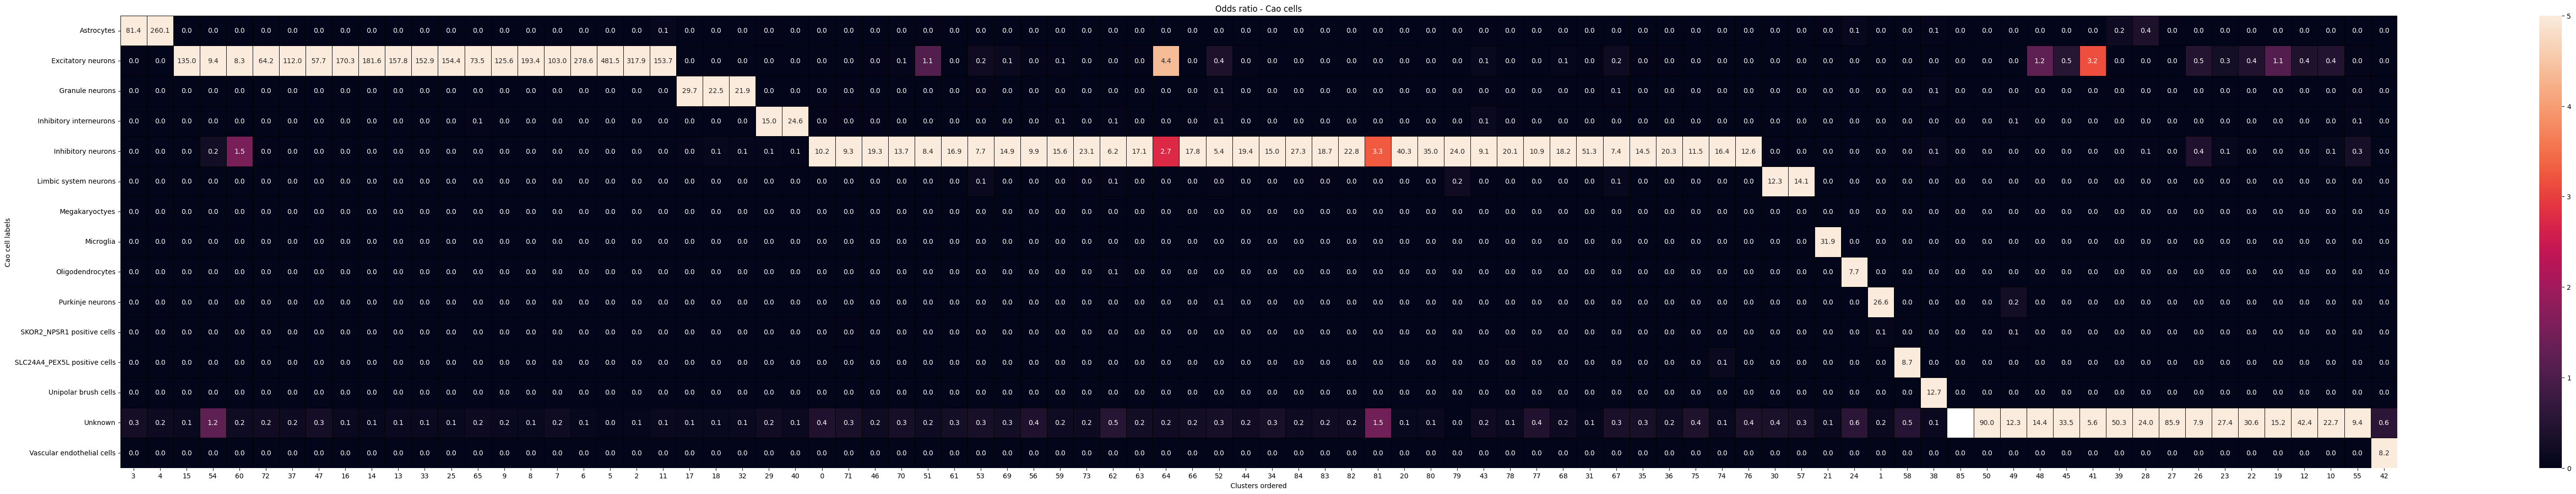

In [6]:
# Makes the odds ratio heatmap

# Create a pivot table
pivot_table = counts.pivot_table(index='Main_cluster_name', columns='leiden', values='count', fill_value=0)
pivot_table_ordered = pivot_table.reindex(columns=cluster_order)


odds_ratio_vals = list()
for cluster in pivot_table_ordered:
    #print(cluster) # 4 
    counter = 0
    for cell in pivot_table_ordered[cluster]:
        #print(cell) # Braun cell classes
    #     #print(type(pivot_table[garnett]))
        a = cell # integer value 
        #print(a)
        b = pivot_table_ordered[cluster].sum() - cell # 7391
        #print(b)
        c = pivot_table_ordered.loc[most_common_list[counter]].sum() - cell
        d = len(adata_cao) - c - b - a
        counter = counter + 1
        odds_r = (a / c) / (b / d)
        odds_ratio_vals.append(odds_r)

# Reshape the list into a 2D numpy array with shape (11, 9)
reshaped_array = np.array(odds_ratio_vals).reshape(cluster_len, 15)

# Convert the 2D numpy array into a pandas DataFrame
odds_df = pd.DataFrame(reshaped_array)

labels = ["Astrocytes", "Excitatory neurons", "Granule neurons", "Inhibitory interneurons", "Inhibitory neurons", "Limbic system neurons", "Megakaryoctyes", "Microglia", "Oligodendrocytes", "Purkinje neurons", "SKOR2_NPSR1 positive cells", "SLC24A4_PEX5L positive cells", "Unipolar brush cells", "Unknown", "Vascular endothelial cells"]

odds_df_t = odds_df.T
odds_df_t.index = labels
odds_df_t.columns = cluster_order

q3 = odds_df_t.quantile(0.75)
# Plot heatmap
plt.figure(figsize=(75, 12))
sns.heatmap(odds_df_t, annot=True, fmt=".1f", vmax=5, linewidths=0.5, linecolor='black')
plt.title('Odds ratio - Cao cells')
plt.xlabel('Clusters ordered')
plt.ylabel('Cao cell labels')
plt.show()


Cluster Proportions: Calculates the proportion of each cell type in each leiden cluster by dividing each value by the row sum.

Heatmap Generation:

    The first subplot shows the proportion of each cell type across clusters.
    The second subplot displays the total and percentage of cell types across all clusters.

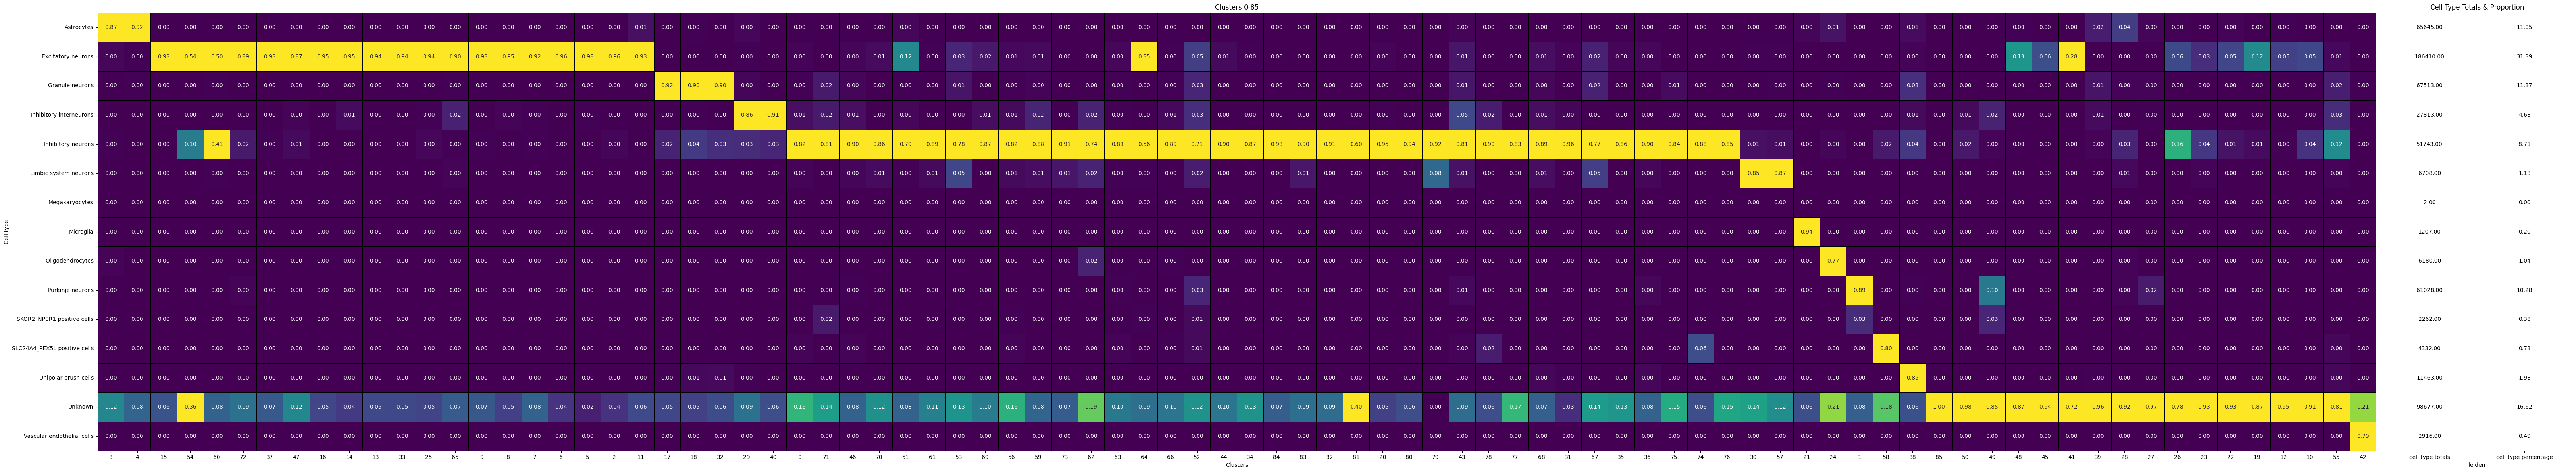

In [7]:
# makes cluster proportion heatmap

# Divide each cell by the row sum to get the proportion
pivot_table_ordered['cell type totals'] = pivot_table_ordered.iloc[:,:cluster_len].sum(axis=1)
pivot_table_ordered['cell type percentage'] = 100 * pivot_table_ordered['cell type totals'] / len(adata_cao)


pivot_table_prop = pivot_table_ordered.copy()
for cluster in cluster_order:  # Assuming you have clusters numbered from 0 to 46
    pivot_table_prop[cluster] = pivot_table_prop[cluster] / pivot_table_prop[cluster].sum()

# Assuming your dataframe is named df
# Create figure and axes for subplots
fig, axes = plt.subplots(1, 2, figsize=(65, 12), gridspec_kw={'width_ratios': [12, 1]})

# Calculate the quartiles for the first heatmap
q1 = pivot_table_prop.iloc[:, :cluster_len].quantile(0.25).min()
q3 = pivot_table_prop.iloc[:, :cluster_len].quantile(0.75).max()

# First subplot: heatmap for columns 0 through 45
sns.heatmap(pivot_table_prop.iloc[:, :cluster_len], cmap='viridis', ax=axes[0], annot=True, cbar=False, fmt=".2f", vmin=0, vmax=0.25, linewidths=0.5, linecolor='black')
axes[0].set_title('Clusters 0-85')
axes[0].set_xlabel('Clusters')
axes[0].set_ylabel('Cell type')



# Second subplot: heatmap for 'cell type totals' and 'cell type proportion'
sns.heatmap(pivot_table_prop[['cell type totals', 'cell type percentage']], cmap='viridis', ax=axes[1], annot=True, cbar=False, yticklabels=False, alpha = 0, fmt = ".2f")
for text in axes[1].texts:
    text.set_color('black')  # Set text color to white to make it transparent
axes[1].set_title('Cell Type Totals & Proportion')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Cluster Removal: Defines two lists of clusters to be removed based on the previous analyses (odds ratio and proportion plots).

    cluster_to_remove: List of clusters identified for removal due to marker gene results.
    cluster_to_remove_unk: List of additional clusters identified for removal based on unknown or irrelevant cell types.

In [8]:
# COMMENTS BELOW ARE TO CREATE CLEANED DATASET
# Based on the odds ratio and proportion plot, we are planning on removing the following clusters

cluster_to_remove = [54, 60, 51, 64, 52, 81, 67] # + 11 which is due to marker genes
cluster_to_remove_unk = [85, 50, 49, 48, 45, 41, 39, 28, 27, 26, 23, 22, 19, 12, 10, 55]

Filtered Clusters:

    filtered_cluster_order: Removes clusters from cluster_order that are in cluster_to_remove.
    final_cluster_order: Further removes clusters from filtered_cluster_order that are in cluster_to_remove_unk, resulting in the final list of clusters.

In [21]:
# Remove values from cluster_order that are in cluster_to_remove
filtered_cluster_order = [item for item in cluster_order if item not in cluster_to_remove]

# Remove values from cluster_order that are in cluster_to_remove
final_cluster_order = [item for item in filtered_cluster_order if item not in cluster_to_remove_unk]

Filtered AnnData Object:

    adata_filtered: Filters the adata object by removing the clusters specified in cluster_to_remove and cluster_to_remove_unk based on the 'leiden' column. This results in a new AnnData object excluding these clusters.

In [9]:
# Step 2: Filter AnnData object based on the mask
adata_filtered = adata[~adata.obs['leiden'].isin(cluster_to_remove)].copy()
adata_filtered = adata_filtered[~adata_filtered.obs['leiden'].isin(cluster_to_remove_unk)]

    Filtered Subsets for Origins:
        adata_dis_fil: Filters adata_filtered to include only cells from the "Disteche" origin.
        adata_ian_fil: Filters adata_filtered to include only cells from the "Ian" origin.
        adata_cao_fil: Filters adata_filtered to include only cells from the "Cao" origin.

Each of these filtered subsets is saved as a separate AnnData object for further analysis.

In [10]:
adata_dis_fil = adata_filtered[adata_filtered.obs["origin"] == "Disteche"].copy()
adata_ian_fil = adata_filtered[adata_filtered.obs["origin"] == "Ian"].copy()
adata_cao_fil = adata_filtered[adata_filtered.obs["origin"] == "Cao"].copy()

    Normalization:
        For each filtered AnnData object (adata_dis_fil, adata_ian_fil, adata_cao_fil), the sc.pp.normalize_total() function normalizes the gene expression data to the median total counts per cell.
        After normalization, the sc.pp.log1p() function is applied to take the natural logarithm of the expression values (log-transformation), which is often done for better visualization and to stabilize variance in the data.

This prepares the datasets for downstream analysis, such as creating marker gene dotplots.

In [11]:
# makes marker gene dotplots

# Normalizing to median total counts
sc.pp.normalize_total(adata_dis_fil)
sc.pp.log1p(adata_dis_fil)

sc.pp.normalize_total(adata_ian_fil)
sc.pp.log1p(adata_ian_fil)

sc.pp.normalize_total(adata_cao_fil)
sc.pp.log1p(adata_cao_fil)

    Convert "leiden" column to categorical:
        The "leiden" column in each of the filtered AnnData objects (adata_dis_fil, adata_ian_fil, adata_cao_fil) is converted to an integer type and then cast to a categorical type using .astype("category").
    Reorder categories:
        The categories for the "leiden" column are reordered based on the final_cluster_order list for each dataset, using .cat.set_categories(final_cluster_order). This ensures that the clusters are displayed in the specified order for downstream analyses, such as visualizations or clustering.

This prepares the "leiden" column for consistent ordering and correct categorical representation across the datasets.

In [22]:
adata_dis_fil.obs["leiden"] = adata_dis_fil.obs["leiden"].astype(int).astype("category")
adata_ian_fil.obs["leiden"] = adata_ian_fil.obs["leiden"].astype(int).astype("category")
adata_cao_fil.obs["leiden"] = adata_cao_fil.obs["leiden"].astype(int).astype("category")

adata_dis_fil.obs['leiden'] = adata_dis_fil.obs['leiden'].cat.set_categories(final_cluster_order)
adata_ian_fil.obs['leiden'] = adata_ian_fil.obs['leiden'].cat.set_categories(final_cluster_order)
adata_cao_fil.obs['leiden'] = adata_cao_fil.obs['leiden'].cat.set_categories(final_cluster_order)


The marker genes used in the analysis are based on cell types identified in the Cao paper. Each cell type is associated with specific genes, such as "ALDH1L1" and "SLC1A3" for Astrocytes or "SLC17A7" and "NEUROD6" for Excitatory neurons, providing a comprehensive set of markers for various neural cell populations.

In [23]:
# from Cao paper
marker_genes = {'Astrocytes': ['ALDH1L1', 'SLC1A3'], 'Excitatory neurons': ["SLC17A7", "NEUROD6", "MAB21L1"], 'Granule neurons': ['PAX6'], 'Inhibitory interneurons': ['GAD1', 'RELN', 'PAX2'], 'Inhibitory neurons': ["GAD1", "RELN", "CALB1"], 'Limbic system neurons': ['TCF7L2', 'LHX9', 'NECAB2'], 'Microglia': ['CX3CR1', 'P2RY12', 'TMEM119'], 'Oligodendrocytes': ['MOG', 'MAG', 'SOX10', 'OLIG1'], 'Purkinje neurons': ['PCP4', 'GAD1', 'GAD2', 'NECAB2'], 'SKOR2_NPSR1 positive cells': ['CALB1', 'TFAP2A'], 'SLC24A4_PEX5L positive cells': ['SLC24A4', 'PEX5L', 'L3MBTL4'], 'Unipolar brush cells': ['EOMES'], 'Vascular endothelial cells': ['CLDN5', 'SLCO1C1']}

This code generates a dot plot for the expression of marker genes across clusters in the `adata_cao_fil` dataset. 

The data is grouped by the `leiden` clustering and visualized with markers specified in the `marker_genes` dictionary.


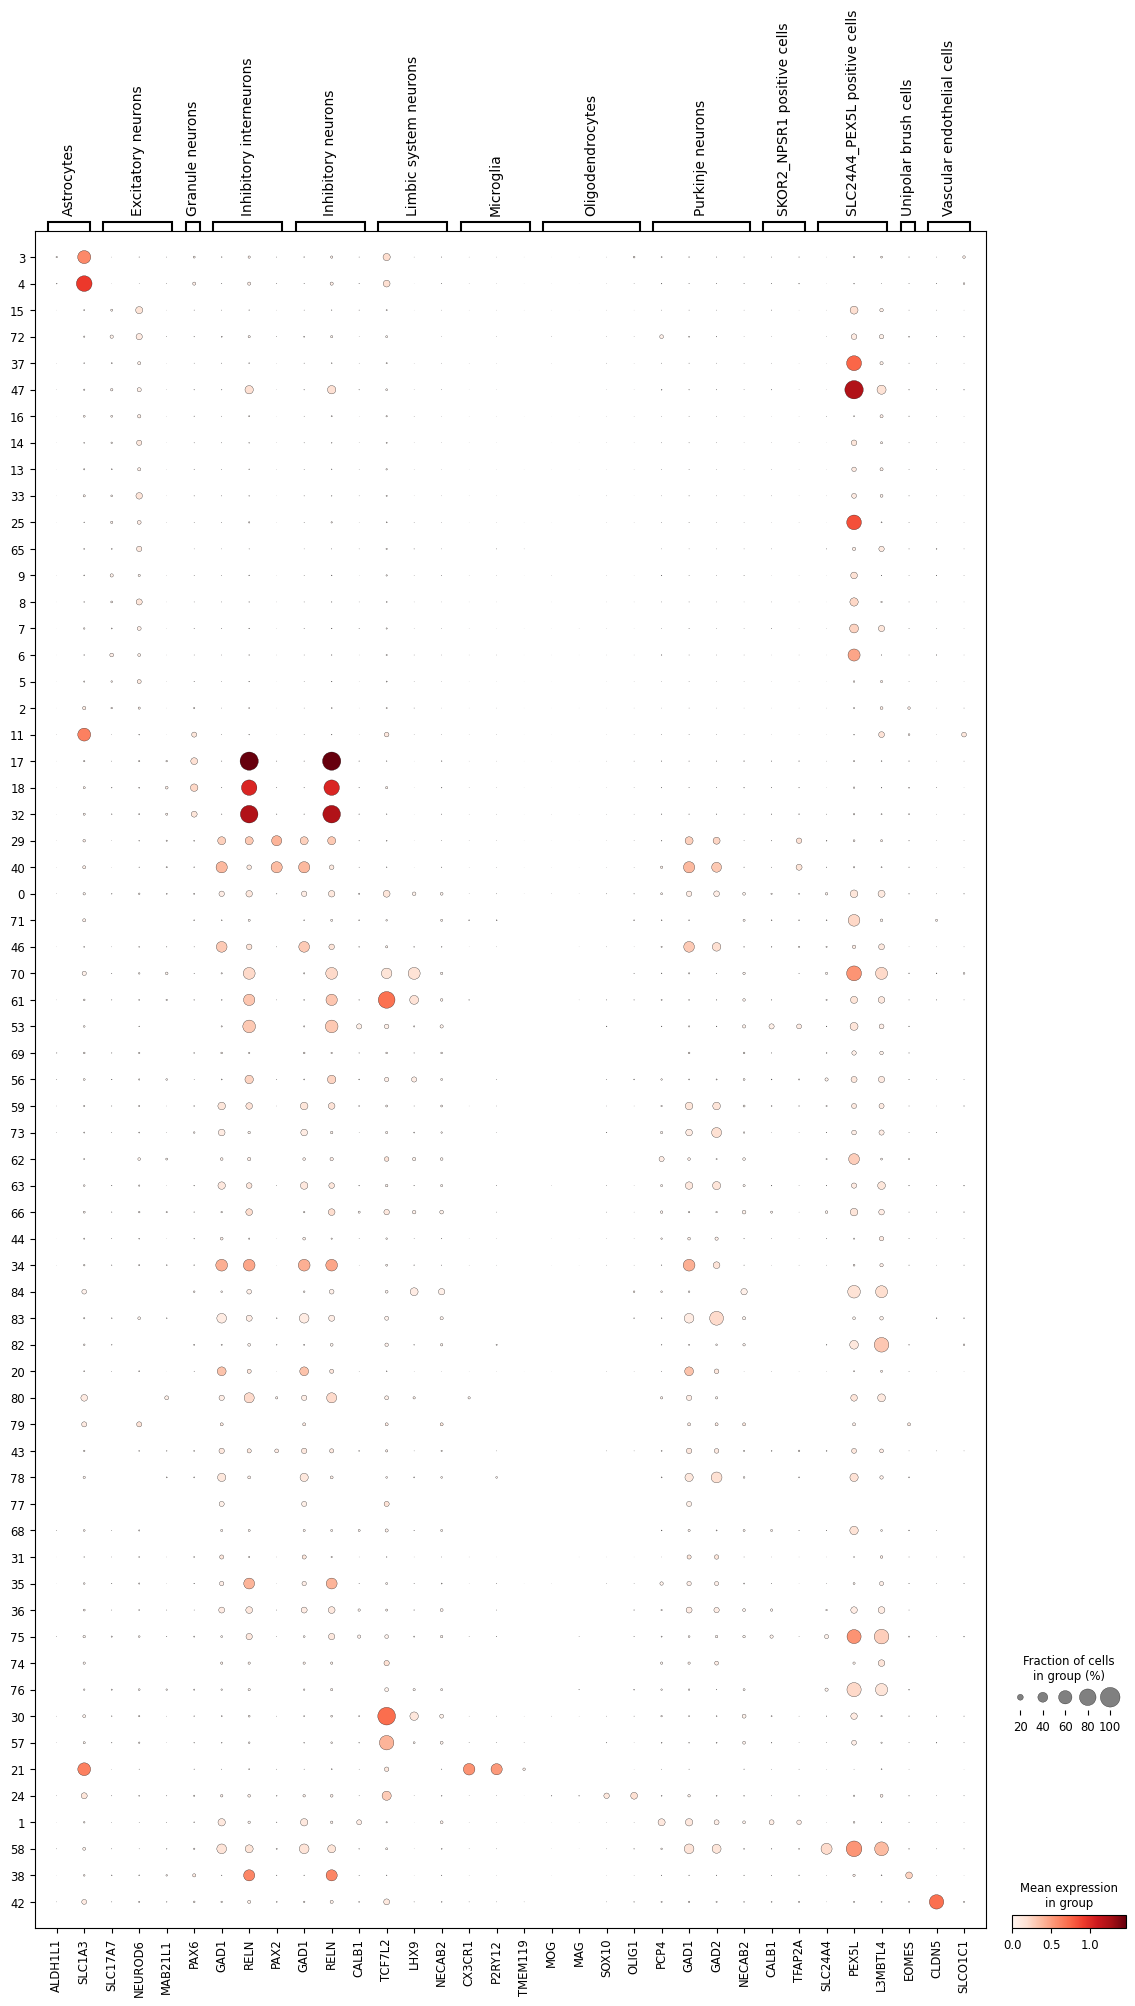

In [24]:
sc.pl.dotplot(adata_cao_fil, marker_genes, groupby='leiden')

See above

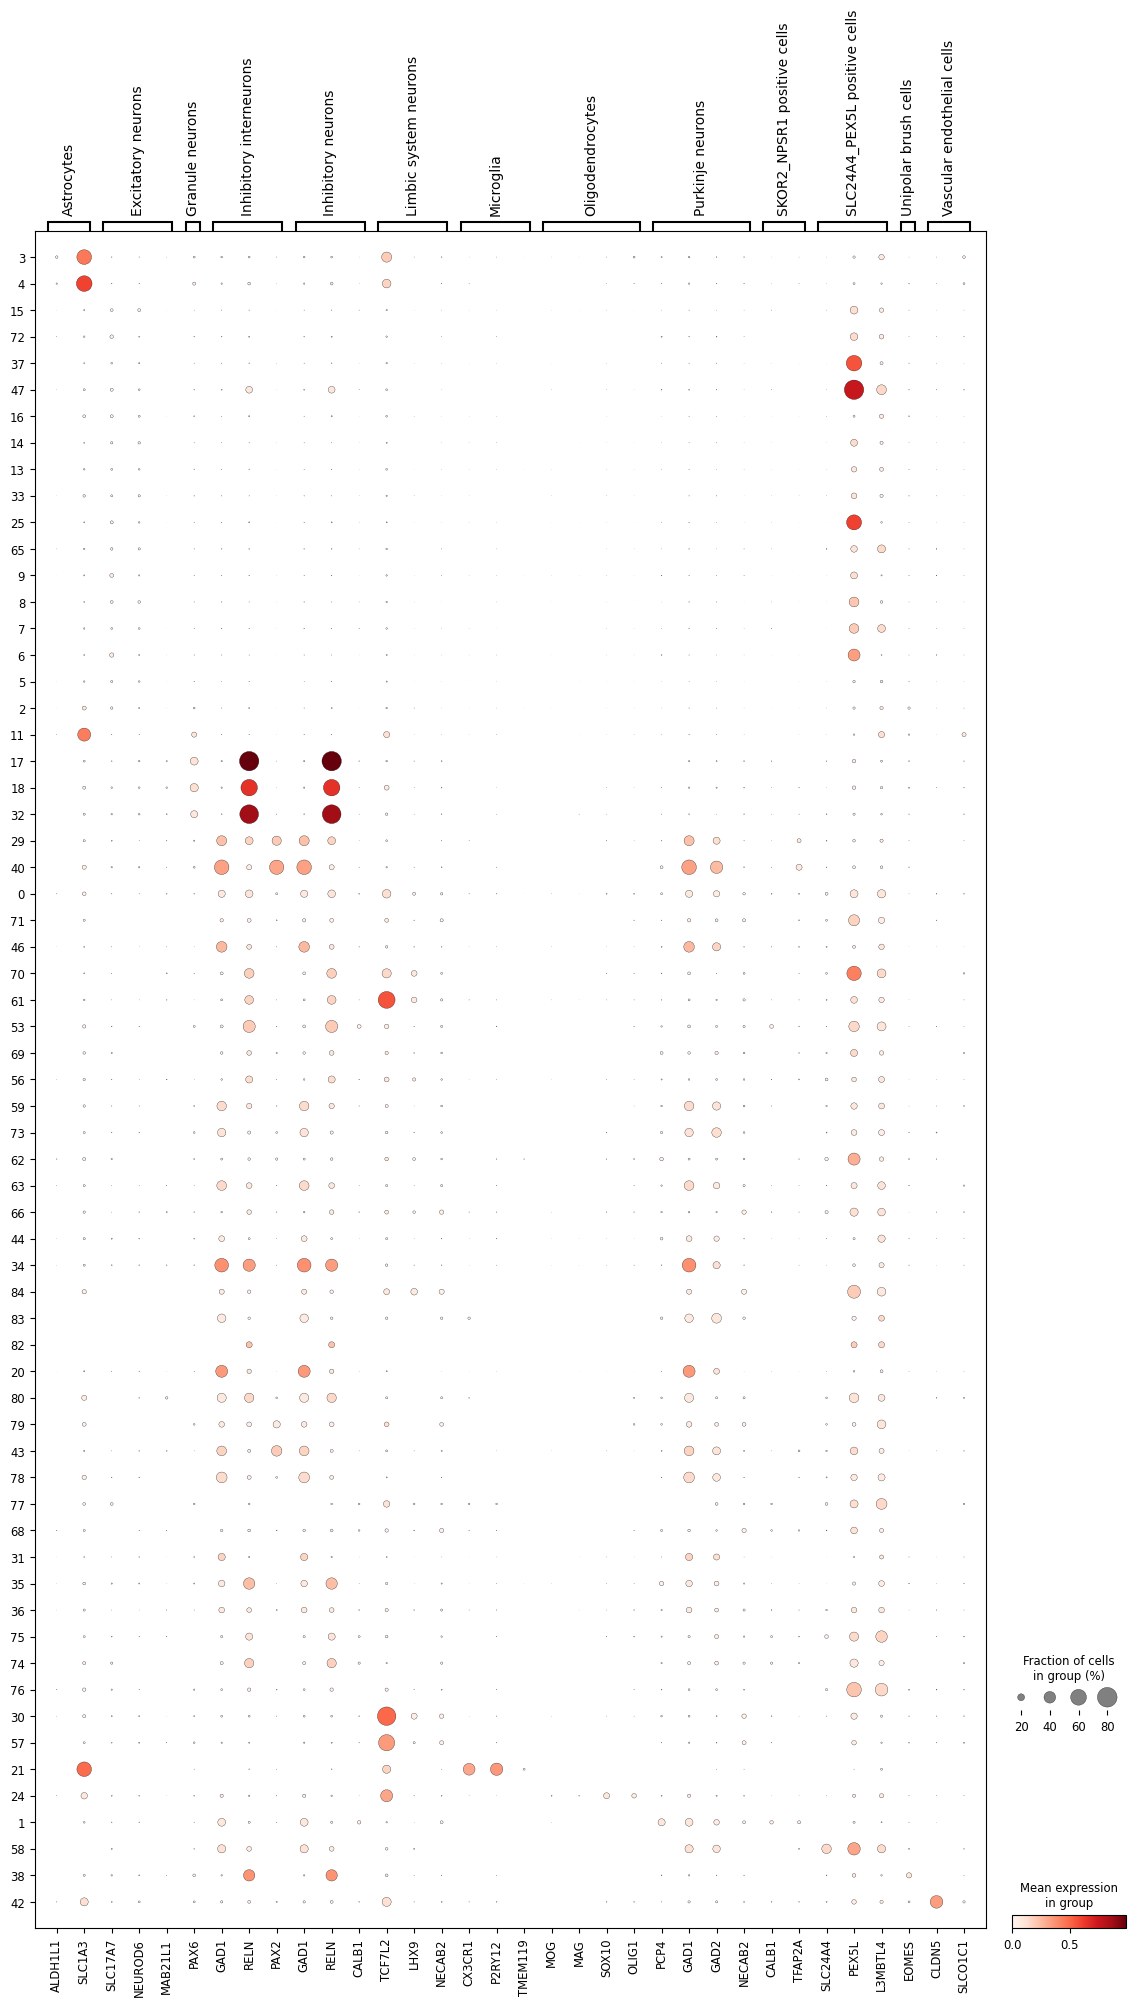

In [25]:
sc.pl.dotplot(adata_ian_fil, marker_genes, groupby='leiden')

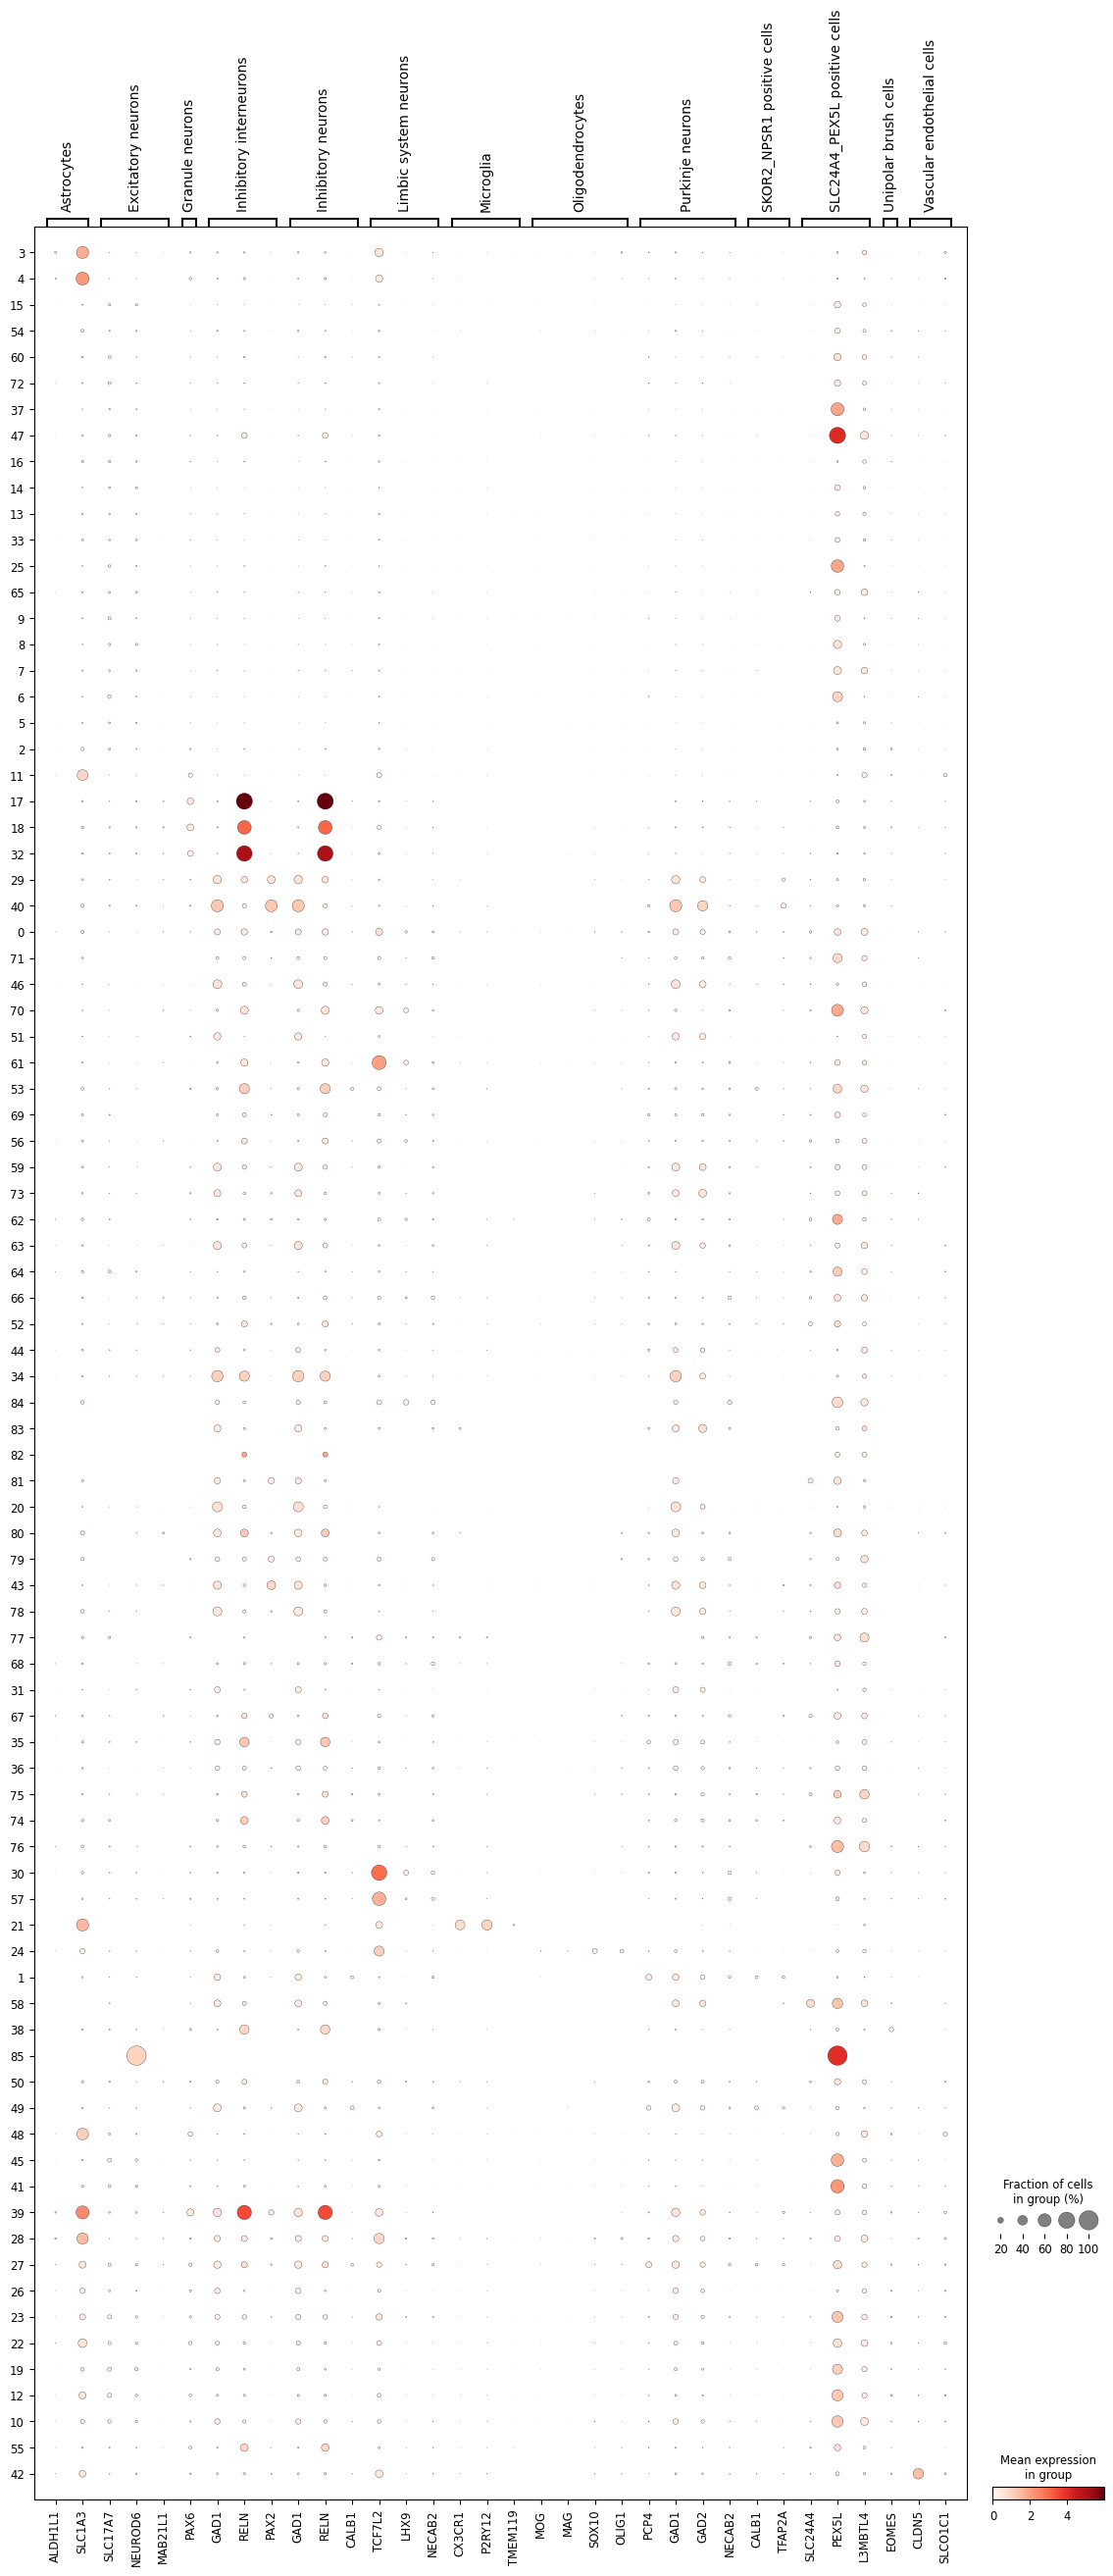

In [26]:
sc.pl.dotplot(adata_ian, marker_genes, groupby='leiden')

In [ ]:
# Based on the marker gene plot, we also want to remove cluster 11